# Vision industrielle - TP 2 

L'objectif de ce TP est de découvrir et d'utiliser des outils d'apprentissages automatiques (machine-learning) dans le cadre de la vision par ordinateur. Le langage de programmation Python sera utilisé, ainsi que les librairies scientifiques suivantes:
- NumPy
- SciPy
- matplotlib
- scikit-image
- sklearn
- opencv

## Objectifs : 
- Première utilisation des points d'intérets et descripteurs (OpenCV inside)
- Reconnaitre des chiffres et des lettres de façon automatique

Installation des dépendances

In [1]:
# executer cette cellule pour charger l'ensemble des fonctions/librairies utiles
%matplotlib notebook
from IPython.core.display import HTML
import requests
from functools import partial
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#%matplotlib inline
import pip
import imageio
import skimage.morphology
import skimage.segmentation
import skimage.feature
import skimage.data
import cv2



plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['figure.figsize'] = 2, 2

def format_coord(x, y, image):
    x = int(x + 0.5)
    y = int(y + 0.5)
    try:
        val = str(image[y, x])
    except IndexError:
        val = "?"
    return "color={} @ [{}, {}]".format(val, y, x)

def display_image_nb(image, title='', cmap=None):
    fig, ax = plt.subplots(1,1)
    if cmap is None:
        ax.matshow(image)
    else:
        ax.matshow(image, cmap=cmap)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def display_image_color(image, title=''):
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def draw_rectangle(y1, x1, y2, x2, color='red', ax=None):
    """ Add a rectangle on an image """
    if ax is None:
        ax = plt.gca()
    rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

print("OK let's go")

OK let's go


# Points d'intérets et descripteurs


/home/lgeorge/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


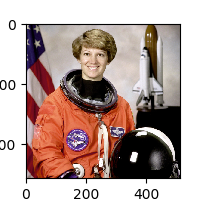

<IPython.core.display.Javascript object>


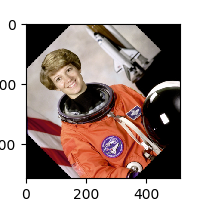

In [2]:
image_1 = skimage.img_as_ubyte(skimage.data.astronaut())
image_2 = skimage.img_as_ubyte(skimage.transform.rotate(image_1, 45))
display_image_color(image_1)
display_image_color(image_2)

De façon à faire matcher les deux images nous allons utiliser les points d'intérets et descripteurs ORB.

Plus d'infos sur les descripteurs ORB:
https://www.google.fr/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjj1ZSZx6PSAhVDOhoKHetjBrAQFggcMAA&url=http%3A%2F%2Fwww.willowgarage.com%2Fsites%2Fdefault%2Ffiles%2Forb_final.pdf&usg=AFQjCNHkIXqNk7-N26SZxzcR-8Oe0JBgpQ



Expliquer ce que fait chacune des lignes suivantes:

<IPython.core.display.Javascript object>


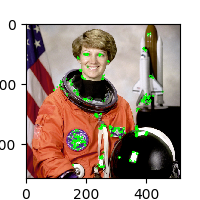

<IPython.core.display.Javascript object>


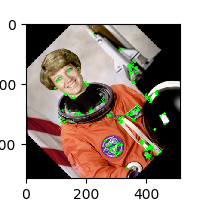

In [3]:
descriptor = cv2.ORB_create()
mask = None
key_points_image_1, features_image_1 = descriptor.detectAndCompute(image_1, mask)
key_points_image_2, features_image_2 = descriptor.detectAndCompute(image_2, mask)
image_1_keypoint = cv2.drawKeypoints(image_1, key_points_image_1, None, color=(0, 255,0))
image_2_keypoint = cv2.drawKeypoints(image_2, key_points_image_2, None, color=(0, 255,0))

display_image_color(image_1_keypoint)
display_image_color(image_2_keypoint)

Utilisez le code suivant pour faire matcher les deux ensembles de points

<IPython.core.display.Javascript object>


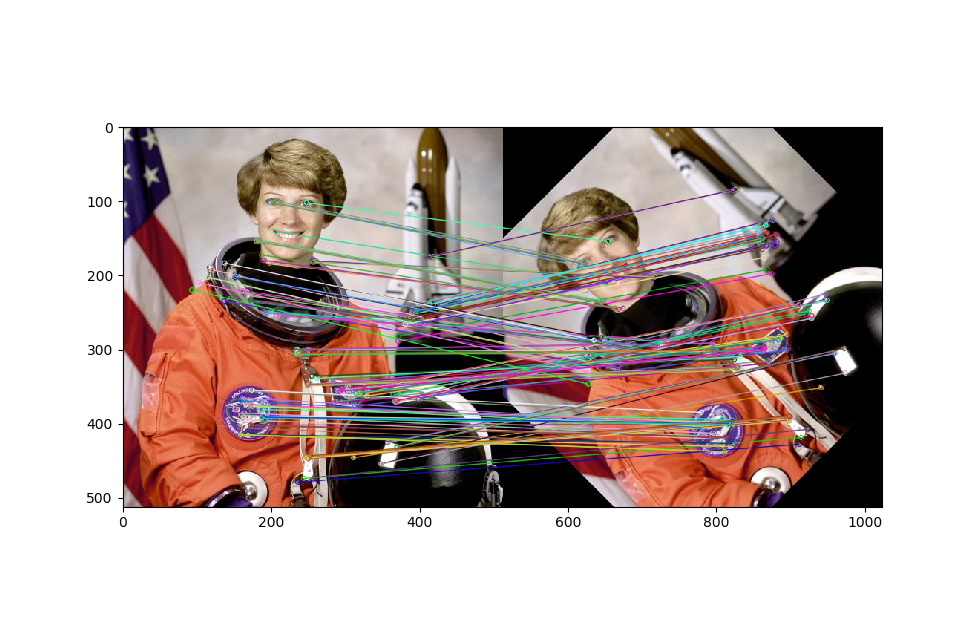

In [4]:
matcher = cv2.DescriptorMatcher_create("BruteForce")  # TODO: regarder les autres 
raw_matches = matcher.knnMatch(features_image_1, features_image_2, 2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in raw_matches:
    if m.distance < 0.7* n.distance:
        good.append(m)
draw_params = dict(# draw matches in green color
                   singlePointColor = None,
                   matchesMask = None,
                   flags = 2)
img3 = cv2.drawMatches(image_1, key_points_image_1, image_2, key_points_image_2, good, None, **draw_params)
display_image_color(img3)

In [5]:
src_pts = np.float32([ key_points_image_1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ key_points_image_2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

# Calcul de l'homograpie entre les points src et dst
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
print(H)

[[ 7.04130993e-01  7.02085080e-01 -1.04349135e+02]
 [-7.07110686e-01  7.05353482e-01  2.54627402e+02]
 [-3.27598216e-06 -7.73339407e-06  1.00000000e+00]]


In [6]:
_, _, _, _, _, rot = cv2.RQDecomp3x3(H)
# rotation correspond à la rotation de l'homographie:
print(rot)



[[ 0.70762986 -0.70658332  0.        ]
 [ 0.70658332  0.70762986  0.        ]
 [ 0.          0.          1.        ]]


## Question
Retrouve t'on bien la rotation appliquée initialement à l'image ?

- aide: https://fr.wikipedia.org/wiki/Matrice_de_rotation
- aide2: combien vaut cosinus(angle_rotation)?

### Mise en pratique:
prenez 2 photos avec des objets identiques dans les deux images et utilisez la détection des points caractéristiques + descripteur ORB afin de visualizer le matching entre les deux images



# Partie 2 : Machine learning

## Introduction: apprentissage automatique

Cette première partie a pour but de vous faire découvrir la librairie sklearn à travers un premier exemple: la reconnaissance de chiffres manuscrits.

### Les données

Dans un premier temps nous chargeons une base d'image de chiffres manuscrits.

Nombre d'image = 1797
Quelques exemples de chiffres présents dans cette base


<IPython.core.display.Javascript object>


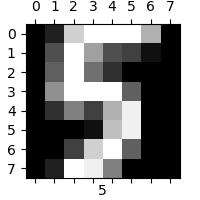

<IPython.core.display.Javascript object>


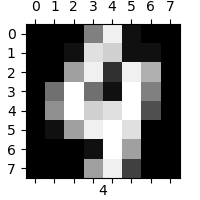

<IPython.core.display.Javascript object>


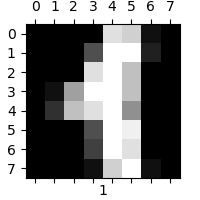

In [9]:
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
digits = sklearn.datasets.load_digits()
print("Nombre d'image = {}".format(digits.data.shape[0]))
print("Quelques exemples de chiffres présents dans cette base")

display_image_nb(digits.images[32], title=digits.target[32])
display_image_nb(digits.images[14], title=digits.target[14])
display_image_nb(digits.images[11], title=digits.target[11])

De combien d'image est constitués le tableau. Quelle est la taille de chaque image ? 

Pour chaque image, nous disposons d'un label correspondant au chiffre présent dans l'image. Ce label est diponnible dans le *tableau digits.target*.

In [8]:
digits.target[11]  # le label associé à l'image 11

1

Quelle chiffre est présent dans l'image 389, quel est le label de cette image ?


Remarquons enfin que les images sont aussi disponnibles en format "plat" (flatten), dans le tableau digits.data

In [ ]:
digits.images[3].flatten()

In [ ]:
digits.data[3]

## Sklearn
Le module sklearn (http://scikit-learn.org) offre un ensemble de fonctions permetant d'utiliser facilement des méthodes d'apprentissages automatisés.



In [12]:
import sklearn.neighbors

# création d'un classifieur
classifier = sklearn.neighbors.KNeighborsClassifier()

# Apprentissage en utilisant la deuxième moitiée de la base de donnée
index = digits.data.shape[0]//2
X = digits.data[index:, :]
Y = digits.target[index:]
classifier.fit(X,Y)

# Maintenant on va utiliser le classifieur pour "prédire" 
# les valeurs présentes dans la première partie de la base de donnée
predicted = classifier.predict(digits.data[:index])
expected = digits.target[:index]


Quelle est la valeur prédite pour le chiffre à la position 15, quelle est la valeur attendue ? La prédiction est t'elle correcte ? Afficher l'image correspondante

Même question pour l'image à la position 120.

### Analyse des performances.

La matrice de confusion permet visualiser la qualité d'un système de classification. 

Le nom "confusion" vient du fait que cette matrice permet facilement de voir si deux classes peuvent être confondues (càd prédire une classe à la place d'une autre).

- ligne:  classe attendue
- colonne:  classe prédite.

Dans le cas d'un système parfait, toutes les valeurs se trouvent sur la diagonale.

Pour plus d'information: https://en.wikipedia.org/wiki/Confusion_matrix

In [14]:
from sklearn import metrics
print("Confusion matrix:\n{}".format(metrics.confusion_matrix(expected, predicted)))

Confusion matrix:
[[90  0  0  0  0  0  0  0  0  0]
 [ 0 90  0  0  0  0  1  0  0  0]
 [ 0  5 82  0  0  0  0  1  3  0]
 [ 0  0  0 88  0  0  0  0  3  1]
 [ 0  7  0  0 80  0  1  1  0  0]
 [ 0  0  0  0  0 89  0  0  0  2]
 [ 0  1  0  0  0  1 88  0  0  0]
 [ 0  0  0  0  0  0  0 90  0  0]
 [ 0  6  0  1  0  0  0  0 79  0]
 [ 0  3  0  0  5  1  0  2  2 75]]


En utilisant cette matrice de confusion, répondez au question suivantes:

- Combien de fois le chiffre 9 a été bien prédit ? (**True positive**, **HIT**)

- Combien de fois le chiffre 9 à été prédit alors qu'il s'agissait d'un autre chiffre ? (**False positive**)

- Combien de fois un chiffre autre que 9 a été prédit alors que le chiffre 9 était attendu ? (**False Negative**)

Quel est le pourcentage de bonnes réponses du classifieur (accuracy)?

Precision et rappel (recall)

rappel = True positive / (True positive + False negative)

précision  = True positive / (True positive + False positive)


Une précision élevée implique qu'on ne se trompe pas quand on prédit une valeur (autrement dit on est sur de nous quand on donne une valeur).

Un rappel élevé signifie qu'on est capable de bien prédire un grand nombre des éléments qui nous interessent.

Remarque, il est facile d'avoir une précision élevée si on a un rappel très faible.

Quel est la précision pour le chiffre 9?
Quel est le rappel pour le chiffre 9 ?

Sklearn fournit une méthode de génération de rapport sur un classifieur: metrics.classification_report.

Utilisez cette méthode pour afficher le rapport concernant le classifieur précédent.

Cross validation 



Apprendre sur des données et tester sur ces mêmes données est une erreur méthodologique. Il faut toujours évaluer les performances sur des données qui n'ont pas été utilisées pour l'apprentissage. Cette approche nécessite d'avoir un jeu de donnée d'apprentissage (X_learn, Y_learn) et un jeu de donnée de test (X_test, Y_test).

Cependant partitionner les données disponnibles en deux ensembles réduit drastiquement le nombre de données utilisables pour apprendre le modèle, de plus le résultat pourrait être dépendant du choix du partitionement.

Une solution est d'utiliser un schéma de type cross-validation.

Lisez la documentation de cross_validation.cross_val_score et utilisez cette méthode.

k-fold cross validation:

- partitionner les données en k sous ensembles
pour i allant de 0 à k:
    - apprendre sur les sous ensembles [0, .., i-1, i+1, .. k]
    - tester sur le jeu de donnée i
- Moyenner les résultats



Exercice: 


Classifier le dataset digits avec un classifieur de type nearest neighbors et un classifieur de type gaussian naive bayesian. Garder 20 % des données de côté pour évaluer les performances de chaque classifieur.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits


# Et si on travaillait avec des images plus grandes..

Mnist dataset:
The MNIST database contains a total of 70000 examples of handwritten digits of size 28x28 pixels, labeled from 0 to 9.

http://yann.lecun.com/exdb/mnist/



In [ ]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=".")
image_nb = mnist.data[22222].copy()
image_nb.shape = (28,28)
image_nb.shape

display_image_nb(image_nb)

/home/lgeorge/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/lgeorge/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


Utilisez la méthode cross_validation.cross_val_score pour évaluer un classifieur de type naive_bayes sur ces données.

Quelle solution pouvez vous proposez pour améliorer les résultats ?